# Data Collection

For the first step of the Yelp review analysis, we scraped all reviews of all restaurants in Pittsburgh, PA, United States with the following scraper pipeline. In this pipeline, we scrape name of restaurant, level of price (from 1 to 5), sub-category (basically the country of the restaurant), user name, date of review, star given (from 0 to 5) and the text of review.

In [ ]:
# setup library imports
import io, time, json, random
import requests
from bs4 import BeautifulSoup
import pandas as pd

# import yelp client library
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator

def authenticate(config_filepath):
    """
    Create an authenticated yelp-python client.

    Args:
        config_filepath (string): relative path (from this file) to a file with your Yelp credentials

    Returns:
        client (yelp.client.Client): authenticated instance of a yelp.Client
    """

    conf = open(config_filepath, 'r')
    cred = json.load(conf)
    auth = Oauth1Authenticator(**cred)
    client = Client(auth)
    return client


def parse_page(html, name = None, price = None, categories = None):
    """
    Parse the reviews on a single page of a restaurant.

    Args:
        html (string): String of HTML corresponding to a Yelp restaurant
        name (string): String of name of restaurant
        price (int): price level of the restaurant
        categories (string): String of categories of restaurant, seperated by comma

    Returns:
        tuple(list, string): a tuple of two elements
            first element: String of name of restaurant
            second element: price level of the restaurant
            third element: String of categories of restaurant, seperated by comma
            fourth element: list of dictionaries corresponding to the extracted review information
            fifth element: URL for the next page of reviews (or None if it is the last page)
    """

    soup = BeautifulSoup(html, 'html.parser')
    results = []
    attr_review = {'itemprop':'review'}
    attr_date = {'itemprop':'datePublished'}
    attr_rate = {'itemprop':'ratingValue'}
    attr_text = {'itemprop':'description'}
    attr_user = {'itemprop': 'author'}

    if name == None:
        name = soup.find('h1').text.strip()
        price_category = soup.find('div', class_='price-category')
        price_tag = price_category.find('span', class_='business-attribute price-range')
        if price_tag == None:
            price = -1
        else:
            price = len(price_tag.text)

    for review in soup.findAll('div', attrs = attr_review):
        user = review.find('meta', attrs = attr_user)['content']
        date = review.find('meta', attrs = attr_date)['content']
        rate = float(review.find('meta', attrs = attr_rate)['content'])
        text = review.find('p', attrs = attr_text).text
        results.append([name, price, categories, user, date, rate, text])

    nextpage = soup.find('a', class_='u-decoration-none next pagination-links_anchor')
    if nextpage == None:
        return (name, price, categories, results, None)

    return (name, price, categories, results, nextpage['href'])

def extract_reviews(url, categories):
    """
    Retrieve ALL of the reviews for a single restaurant on Yelp.

    Parameters:
        url (string): Yelp URL corresponding to the restaurant of interest.
        categories (string): The categories of the page.

    Returns:
        reviews (list): list of dictionaries containing extracted review information
    """

    html = requests.get(url).content
    name, price, categories, allreviews, nextpage = parse_page(html, categories = categories)
    while (nextpage != None):
        # wait a random time to avoid being detected scraper
        time.sleep(0.5 + random.random())
        html = requests.get(nextpage).content
        _, _, _, reviews, nextpage = parse_page(html, name, price, categories)
        allreviews.extend(reviews)

    print 'Extracted %d reviews from this business' % len(allreviews)

    return allreviews

def all_restaurants(client, query, category = None):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of yelp.obj.business.Business objects
    """

    results = []
    if category == None:
        param = {'term': 'restaurants'}
    else:
        param = {'term': 'restaurants', 'category_filter': category}

    response = client.search(query, **param)

    total = response.total
    if total > 1000:
        print 'Trying to get over 1000 records (%d), set to 1000' % total
        total = 1000

    i = 0
    for business in response.businesses:
        i += 1
        print i, '/', total, ':\n', business.url
        try:
            results.extend(extract_reviews(business.url, category))
        except Exception:
            print 'Oh maybe we are recognized as a scraper'
            raw_input('Visit Yelp and pass the validation, then press any key to continue')
            try:
                results.extend(extract_reviews(business.url, category))
            except Exception:
                print 'Failed, try again'
                raw_input('press any key to continue')
                continue
            continue

    while i < total:
        param['offset'] = i
        response = client.search(query, **param)
        for business in response.businesses:
            i += 1
            print i, '/', total, ':\n', business.url
            try:
                results.extend(extract_reviews(business.url, category))
            except Exception:
                print 'Oh maybe we are recognized as a scraper'
                raw_input('Visit Yelp and pass the validation, then press any key to continue')
                try:
                    results.extend(extract_reviews(business.url, category))
                except Exception:
                    print 'Failed, try again'
                    raw_input('press any key to continue')
                    continue
                continue
    return results

if __name__ == '__main__':
    reviews = []
    random.seed(15688)
    client = authenticate('yelp.json')
    with open('category.list', 'r') as category_file:
        for line in category_file:
            print line
            if not line.startswith('#'):
                reviews.extend(all_restaurants(client, 'Pittsburgh, PA', line.strip()))
    pd.DataFrame(reviews).to_pickle('dataset.pickle')


Note: This piece of code with take several hours to run (12 hours on my Macbook Air!), and it could be interrupted by the Yelp scraper detection serveral times where we will need to manually pass the validation in this case. So we don't recommend you to run this piece of code in the notebook, the python script file can be found [here](https://github.com/lidajian/YelpAnalysis/blob/master/scraper.py).

The scraped data in can be found in our [github](https://github.com/lidajian/YelpAnalysis/blob/master/data/pittsburgh_restaurants.pickle), the data file is in Python pickle format and can be easily imported as `pandas.DataFrame` object.

In [2]:
import pandas as pd
df = pd.read_pickle("./data/pittsburgh_restaurants.pickle")
df.columns = ['restaurant', 'price_range', 'category', 'user', 'date', 'rating', 'review']

First let's have a glimpse to the data we have

In [63]:
print df.dtypes
print df.head()

restaurant      object
price_range      int64
category        object
user            object
date            object
rating         float64
review          object
dtype: object
    restaurant  price_range category        user        date  rating  \
0  Grandma B’s            1    halal     Mark R.  2016-11-03     5.0   
1  Grandma B’s            1    halal      Dan T.  2016-09-18     4.0   
2  Grandma B’s            1    halal  Maurice J.  2016-06-13     5.0   
3  Grandma B’s            1    halal    Karol R.  2016-07-13     5.0   
4  Grandma B’s            1    halal        T R.  2016-08-28     5.0   

                                              review  
0  Halal hot wings very tasty, well seasoned, fis...  
1  Mom and pop stop - cheap, good and affordable,...  
2  I've frequented this place on several occasion...  
3  Breakfast is cooked to order. The food is deli...  
4  This place is RIDICULOUSLY GOOD. I got eggs, p...  


Before we can do high level analysis to the scraped data, let's first take a simple analysis to the data we scraped.

# Simple Analysis to Data

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

A statistical summary of price range and rating is shown:

In [43]:
print df.describe()

       price_range        rating
count  76989.00000  76989.000000
mean       1.90144      3.721038
std        0.56156      1.273594
min       -1.00000      1.000000
25%        2.00000      3.000000
50%        2.00000      4.000000
75%        2.00000      5.000000
max        4.00000      5.000000


Note: The reason the minimum price range is -1 is that when we scraped the price we found some of the restaurant don't have price range label. We ignore all reviews that have no price data when analysing relations of price.

In [44]:
df_price = df[df['price_range'] >= 0]

## Restaurants at different price range
An histgram of restaurants at different price range is shown below:

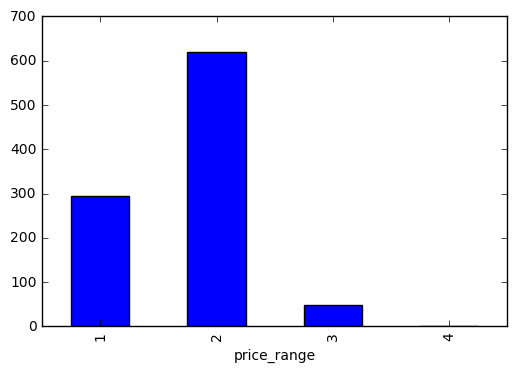

In [45]:
df_price.groupby(by = 'price_range')['restaurant'].apply(lambda x: len(pd.Series.unique(x))).plot(kind = 'bar')

As shown in the histgram, the distribution tends to be bell shaped distribution, with most restaurants at price range 2 (\$11 - 30). This indicates that restaurants at price range 2 are the common choice when people choose to open a restaurant.

## Reviews with different ratings

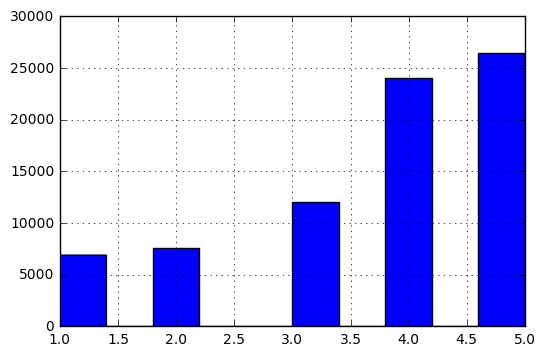

In [47]:
df['rating'].hist()

Normally we expect the rating to be a bell shaped distribution. But in the histgram, the evaluation of customers seems to be quite good, so more reviews are at higher ratings.

## Correlation between price range and rating

Does higher price indicate higher food and service quality? Let's make a histgram to figure out:

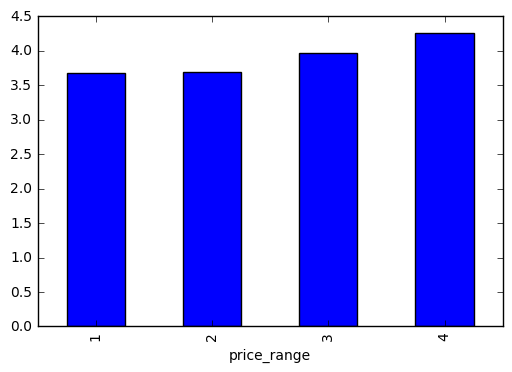

In [50]:
df_price.groupby(by = 'price_range')['rating'].mean().plot(kind = 'bar')

There are a certain correlation between price and review stars. For higher price review stars tends to be higher. However the difference between price range 1 and price range 2 is quite small.

## Correlation between price and average number of reviews

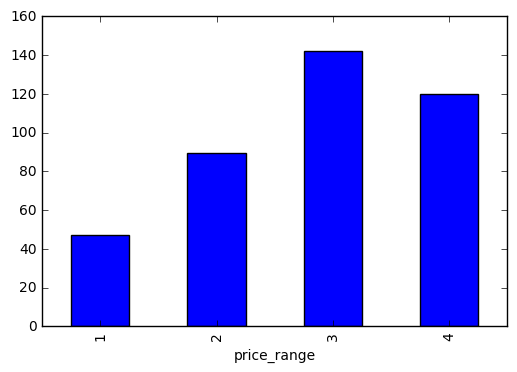

In [56]:
df_price.groupby(by = 'price_range').apply(lambda x: float(x.shape[0])/len(x['restaurant'].unique())).plot(kind = 'bar')

Price range 3 has the largest average number of reviews.

# Categorized Analysis

## Average ratings of different sub-categories

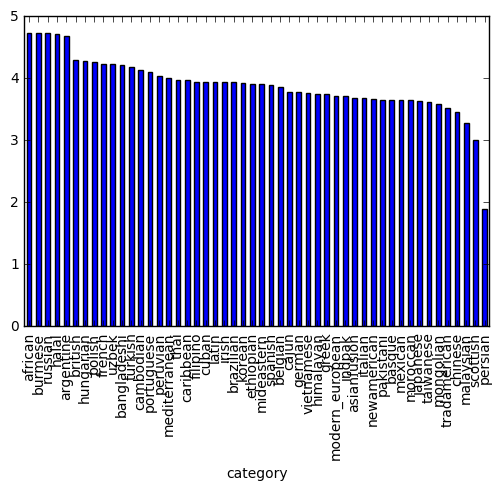

In [64]:
df.groupby(by = 'category')['rating'].mean().sort_values(ascending = False, inplace = False).plot(kind = 'bar')

We actually have a [list](https://github.com/lidajian/YelpAnalysis/blob/master/category.list) that categorize sub-categories into different regions. 
 
* middle east asia
* east asia
* south asia
* europe
* north american
* south american
* africa

To use the category list, we first import it from file.

In [3]:
def load_category (file_name):
    categories_name = []
    categories = {}
    temp = open(file_name,'r').read().split('\n')
    
    for term in temp:
        if term.startswith("#"):
            categories[term[2:]]=set()
            categories_name.append(term[2:])
            
        else:
            categories[categories_name[len(categories_name)-1]].add(term)
   
    return categories_name, categories

This is a glimpse of all categories:

In [4]:
categories_name, categories = load_category("category.list")
for name in categories_name:
    print 'Category: ', name, '\t#sub-categories:',len(categories[name])
    print categories[name]

Category:  middle east asia 	#sub-categories: 9
set(['indpak', 'arabian', 'mideastern', 'halal', 'himalayan', 'afghani', 'pakistani', 'syrian', 'persian'])
Category:  east asia 	#sub-categories: 9
set(['hkcafe', 'chinese', 'panasian', 'taiwanese', 'japanese', 'asianfusion', 'mongolian', 'korean', 'thai'])
Category:  south asia 	#sub-categories: 8
set(['singaporean', 'filipino', 'vietnamese', 'malaysian', 'bangladeshi', 'burmese', 'laotian', 'cambodian'])
Category:  europe 	#sub-categories: 28
set(['portuguese', 'irish', 'czech', 'basque', 'mediterranean', 'moroccan', 'spanish', 'scottish', 'srilankan', 'polish', 'modern_european', 'turkish', 'german', 'belgian', 'austrian', 'hungarian', 'ukrainian', 'french', 'iberian', 'catalan', 'slovakian', 'armenian', 'russian', 'uzbek', 'british', 'scandinavian', 'greek', 'italian'])
Category:  north american 	#sub-categories: 8
set(['cajun', 'tradamerican', 'mexican', 'nicaraguan', 'hawaiian', 'newmexican', 'caribbean', 'newamerican'])
Category: 

In [5]:
category_dict = {}
for name in categories_name:
    for category in categories[name]:
        category_dict[category] = name
df_categorized = df.copy()
df_categorized['category'] = df_categorized['category'].apply(lambda x: category_dict[x])

Then, let us explore the overal statistic of each category:

We load the data into a dictionay `processed_category`

In [25]:
processed_category = {}
for name in categories_name:
    processed_category[name] = df_categorized[df_categorized['category'] == name].copy()
    processed_category[name].reindex()

In [75]:
print '%20s|\t%10s|\t%10s|\t%10s|\t%10s|\t%10s' % ('category','number','rating(mean)','rating(variance)','price(mean)','price(variance)')
print '------------------------------------------------------------------------------------------------------------------'
for name in processed_category.keys():
    print '%20s|\t%10d|\t%10.4f|\t%10.4f|\t%10.4f|\t%10.4f' % (name, len(processed_category[name]), 
                                    processed_category[name]['rating'].mean(),  processed_category[name]['rating'].var(),
                                    processed_category[name]['price_range'].mean(),  processed_category[name]['price_range'].var()        )


            category|	    number|	rating(mean)|	rating(variance)|	price(mean)|	price(variance)
------------------------------------------------------------------------------------------------------------------
              europe|	     18370|	    3.8431|	    1.5909|	    1.9820|	    0.3664
           east asia|	     15963|	    3.6981|	    1.6363|	    1.8530|	    0.2736
    middle east asia|	      2802|	    3.8269|	    1.6091|	    1.8837|	    0.1307
              africa|	       111|	    4.0541|	    0.9607|	    1.8108|	    0.2093
      north american|	     35632|	    3.6169|	    1.6458|	    1.8898|	    0.3233
          south asia|	      1528|	    3.8364|	    1.4192|	    1.5988|	    0.2443
      south american|	      2583|	    4.2350|	    1.0458|	    1.9911|	    0.2226


[-1, 7, 0, 6]

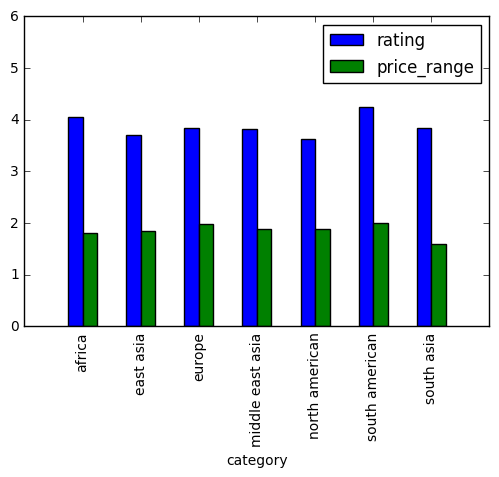

In [12]:
df_categorized.groupby(by = 'category')['rating', 'price_range'].mean().plot(kind = 'bar').axis([-1, 7, 0, 6])

## Word Cloud

In [18]:
import nltk
from collections import Counter

import string
import numpy as np
import sklearn
import scipy.sparse as sp
import math

We define a function to tokenize the text reviews

In [19]:
from nltk.stem import WordNetLemmatizer
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    text = text.lower()
    text = text.replace("'s","")
    text = text.replace("'","")
    replace_punctuation = string.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(replace_punctuation)
    
    tokens = nltk.word_tokenize(text)
    ans = []
    for token in tokens:
        try:
            lemma = lemmatizer.lemmatize(token)
            ans.append(lemma)
        except:
            pass
    return ans

In [ ]:
for name in categories_name:
    processed_category[name]['review'] = processed_category[name]['review'].apply(lambda x: process(x.encode('utf-8')))

### Cross-category analysis

Firstly, we need to remove the stopwords and count the unigram(single words)

In [23]:
from collections import Counter
from string import punctuation

def word_counter(all_review, n=50):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    with_stp = Counter()
    without_stp  = Counter()
    for review in all_review:
        with_stp.update(w for w in review if w in stopwords)
        without_stp.update(w for w in review if w not in stopwords)
    return [x for x in with_stp.most_common(n)],[y for y in without_stp.most_common(n)]



We then use the wordCloud to visualize the most common words of each category. WordCloud is a convenient opensourse tool, which can download from http://amueller.github.io/word_cloud/

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_wordCloud(processed_category):
    for name in processed_category.iterkeys():
        with_stp, without_stp = word_counter(processed_category[name]['review'], 200)
        str = ""
        w =  [pair[0] for pair in without_stp]
        str = " ".join(w)
        wordcloud = WordCloud(background_color='white',width=1800,height=1900).generate(str)
        plt.figure(i+1, figsize=(10,10), dpi=100)
        plt.axis('off')
        plt.title (name, size=30)
        plt.imshow(wordcloud, cmap=plt.cm.gray)

plot_wordCloud(processed_category)

### LDA model

gensim is a powerful tool to generate topic models, and we generate 20 topis for each type of restaurants.

in order to use gensim, we need to fisrt install gensim using: 

pip install gensim

In [26]:
import gensim
from gensim import corpora, models,matutils

lda_corpus_each_region = {}
lda_model_each_region = {}
for name in processed_category.keys():
    print 'analying LDA model of ' + name
    data_list = processed_category[name]['review']
    dic =corpora.Dictionary(data_list)
    corpus = [dic.doc2bow(text) for text in data_list] # 每个text 对应的稀疏向量
    tfidf = models.TfidfModel(corpus) #统计tfidf
    corpus_tfidf = tfidf[corpus]  #得到每个文本的tfidf向量，稀疏矩阵
    lda = models.LdaModel(corpus_tfidf, id2word = dic, num_topics = 20)
    corpus_lda = lda[corpus_tfidf] #每个文本对应的LDA向量，稀疏的，元素值是隶属与对应序数类的权重
    lda_corpus_each_region[name] = corpus_lda
    lda_model_each_region[name] = lda


analying LDA model of europe
analying LDA model of east asia
analying LDA model of middle east asia
analying LDA model of africa
analying LDA model of north american
analying LDA model of south asia
analying LDA model of south american


Our LDA model is now stored as ldamodel. We can review our topics with the print_topic and print_topics methods, let us analyse the topics of europe, These are the top 5 words associated with 5 random topics. The decimal number is the weight of the word it is multiplying, i.e., how much does this word influence the particular topic.

In [42]:
europe_topics = (lda_model_each_region['europe']).show_topics(num_topics=5, num_words=10)
for topic in europe_topics:
    print topic
    print

(115, u'0.043*"tomorrow" + 0.041*"frequently" + 0.033*"driving" + 0.024*"plastic" + 0.023*"wonderfully" + 0.021*"pro" + 0.021*"stepping" + 0.021*"dropping" + 0.020*"exact" + 0.019*"con"')

(92, u'0.015*"grill" + 0.014*"owner" + 0.012*"sofra" + 0.010*"platter" + 0.007*"yogurt" + 0.006*"clean" + 0.006*"lamb" + 0.006*"salumi" + 0.005*"amazing" + 0.005*"fresh"')

(147, u'0.022*"med" + 0.020*"alihan" + 0.018*"license" + 0.017*"selling" + 0.016*"grub" + 0.014*"te" + 0.013*"mad" + 0.012*"fettuccine" + 0.012*"pastitsio" + 0.012*"freshness"')

(199, u'0.072*"owned" + 0.054*"shish" + 0.047*"tea" + 0.034*"nicest" + 0.023*"everybody" + 0.023*"burrito" + 0.020*"frequent" + 0.019*"operated" + 0.018*"diet" + 0.015*"family"')

(168, u'0.035*"coworkers" + 0.033*"welcome" + 0.030*"wide" + 0.025*"downside" + 0.023*"kid" + 0.020*"sleek" + 0.017*"allergy" + 0.017*"drive" + 0.015*"alike" + 0.013*"daily"')



** The number of topics needs to be adjust, and we choose to pick 20 topics for each type of restaurants. **

而主题模型是迅速汇总信息的最快方式。用户可以快速探索不同的主题气泡，并基于点评中词条的出现频率找出问题。例如，如果时间是一个很重要的问题，那么用户在开餐厅时就可以利用这一点。

we also want to vesualize the LDA model, so we use the python package pyldavis

pip install pyldavis.  不知道需不需要Visualization LDA model. 看后面我们的篇幅怎么样，下面有两个API可以调用。我觉得第一个比较酷炫，但是第二个比较manual

http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=1&term=

or :

https://de.dariah.eu/tatom/topic_model_visualization.html

### 2gram model ?